In [3]:
!pip install -r requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
import pandas as pd
# from transformers import AutoTokenizer
# from transformers.data.data_collator import DataCollatorForWholeWordMask, DataCollatorForLanguageModeling
# from transformers import LineByLineTextDataset
from nltk import sent_tokenize
from tokenizers import Tokenizer
import torch

In [6]:
df = pd.read_csv(
    'data/jd.csv', 
#     nrows=1000
)

In [7]:
df

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
...,...,...,...,...,...,...,...,...,...,...,...,...
244763,72705211,TEACHER OF SCIENCE,Position: Qualified Teacher Subject/Specialism...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244764,72705212,TEACHER OF BUSINESS STUDIES AND ICT,Position: Qualified Teacher or NQT Subject/Spe...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244765,72705213,ENGLISH TEACHER,Position: Qualified Teacher Subject/Specialism...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244766,72705216,SUPPLY TEACHERS,Position: Qualified Teacher Subject/Specialism...,Wiltshire,Wiltshire,NaN,contract,NaN,Teaching Jobs,450 to 500 per week,22800,hays.co.uk


In [9]:
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', max_length=1024)
tokenizer = Tokenizer.from_file("data/jd_tokenizer_wordpiece.json")
tokenizer.enable_padding()
# tokenizer.add_special_tokens(["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
tokenizer.encode_batch(['small sent', 'a larger sent'])

[Encoding(num_tokens=3, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=3, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [13]:
import random
class DataCollatorForLanguageModeling:
    def __init__(self, tokenizer, mlm_probability=0.15):
        self.tokenizer = tokenizer
        self.mlm_probability = mlm_probability
        self.special_token_ids = []
        self.vocab_size = tokenizer.get_vocab_size()
        for i in range(len(tokenizer.get_vocab())):
            tok = tokenizer.id_to_token(i)
            if tok[0] == '[' and tok[-1] == ']':
                self.special_token_ids.append(i)
            else:
                break
        
    def __call__(self, batch):
        shape = (len(batch), len(batch[0]))
        labels = torch.full(shape, -100)
#         input_ids
        for i in range(len(batch)):
            for j in range(len(batch[0])):
                tok = batch[i][j]
                if tok == 0:
                    break
                else:
                    r1 = random.random()
                    r2 = random.random()
                    if r1 < self.mlm_probability and tok not in self.special_token_ids:
                        if r2 < 0.8:
                            replacement = self.tokenizer.token_to_id('[MASK]')
                        elif r2 < 0.9:
                            replacement = random.randint(100, self.vocab_size-1)
                        else:
                            replacement = tok
                        
                        batch[i][j] = replacement
                        labels[i][j] = tok
        
        return {
            'input_ids': torch.tensor(batch),
            'labels': labels
        }

In [14]:
dc = DataCollatorForLanguageModeling(tokenizer, mlm_probability=0.2)

In [15]:
def get_mlm_batch(sentences):
    sentences = [f'[CLS] {s} [SEP]' for s in sentences]
    toks = tokenizer.encode_batch(
        sentences,
        add_special_tokens=True
    )
    toks = [t.ids for t in toks]
    
    return dc(toks)

In [17]:
get_mlm_batch(['this is a sent', 'this is another sent'])

{'input_ids': tensor([[   2,  220,  200,   37, 4357,    3],
         [   2,  220,  200, 3966, 4357,    3]]),
 'labels': tensor([[-100, -100, -100, -100, -100, -100],
         [-100, -100, -100, -100, -100, -100]])}

In [18]:
def line_by_line_generator(jds, batch_size=32, max_length=128):
    examples = []
    ex = ''
    current_token_count = 0
    while True:
        for jd in jds:
            if len(ex) > 0:
                ex += ' [SEP] '
            sents = sent_tokenize(jd)
            for sent in sents:
                sent_len = len(sent.split())
                if current_token_count + sent_len >= max_length:
                    examples.append(ex)
                    ex = ''
                    current_token_count = 0
                    if len(examples) == batch_size:
                        batch = get_mlm_batch(examples)
                        yield batch
                        examples = []

                ex += sent
                current_token_count += sent_len

In [19]:
for index, batch in enumerate(line_by_line_generator(df.FullDescription, batch_size=4)):
    if index > 5:
        break
#     print(len(batch))
#     print(batch)

In [20]:
batch

{'input_ids': tensor([[    2,   662, 14824,  2937,   569,    27,    12, 26603,    12,    12,
            157,    12,    12,    12,    12,    10,   623,     4,   513,     4,
            711,     4,  2476,    27,  2633,    14,  7576,    14,  1257,  1285,
              3,    37,   543,  3002,  1673,  2476,   160,   153,     4,   850,
            531,    37,  1149,   212,  2612,   278,   985,   278,     4,    37,
           1149,   212,  2612,     4,   200,  1848,   930,   330,   186,     4,
           2444,  1975,   157,    37,   400,   785,   200, 28118,   157,     4,
            153,  5267,   168,     4,   320,   202,  1828,  2036,  1673,    15,
            153,  1673,  7000,    12,    12,     4,     4,  4767,   320,  4261,
            186,    37,  1015,     4,   152,   496,   157,     4,    12,     4,
              4,  4767,   160,   153,     4,   183,   153,     4,  1419, 12057,
           4668,     4,   196,  1149,   212,  2612,   176,     4,   193,     4,
            157,  1270,    

In [26]:
import torch
from torch import nn, optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
class RNN_MLM(nn.Module):
    def __init__(self, tokenizer, embedding_dim=256, model_dim=512):
        super().__init__()
        self.num_tokens = len(tokenizer.get_vocab())
        self.token_embedding = nn.Embedding(self.num_tokens, embedding_dim)
        self.up_scale = nn.Linear(embedding_dim, model_dim)
        self.encoders = nn.ModuleList([nn.LSTM(model_dim, int(model_dim/2), num_layers=1, batch_first=True, bidirectional=True) for _ in range(4)])
        self.output = nn.Linear(model_dim, embedding_dim)
    
        
    def forward(self, x):
        emb = self.token_embedding(x)
        emb = self.up_scale(emb)
        emb = F.relu(emb)
        
        for index, lstm in enumerate(self.encoders):
            out, _ = lstm(emb)
            if index > 0:
                emb = emb + out
            else:
                emb = out

        emb = F.relu(emb)       
        emb = self.output(emb)
 
        output = torch.matmul(emb, self.token_embedding.weight.T)
        
        return output

In [28]:
# device = torch.device('cpu')
# device = torch.device('cuda')

In [29]:
rnn_mlm_model = RNN_MLM(tokenizer)
rnn_mlm_model.to(device)

RNN_MLM(
  (token_embedding): Embedding(36000, 256)
  (up_scale): Linear(in_features=256, out_features=512, bias=True)
  (encoders): ModuleList(
    (0): LSTM(512, 256, batch_first=True, bidirectional=True)
    (1): LSTM(512, 256, batch_first=True, bidirectional=True)
    (2): LSTM(512, 256, batch_first=True, bidirectional=True)
    (3): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (output): Linear(in_features=512, out_features=256, bias=True)
)

In [31]:
optimizer = optim.AdamW(rnn_mlm_model.parameters())

In [32]:
running_loss = 0.0
losses = []

In [33]:
rnn_mlm_model

RNN_MLM(
  (token_embedding): Embedding(36000, 256)
  (up_scale): Linear(in_features=256, out_features=512, bias=True)
  (encoders): ModuleList(
    (0): LSTM(512, 256, batch_first=True, bidirectional=True)
    (1): LSTM(512, 256, batch_first=True, bidirectional=True)
    (2): LSTM(512, 256, batch_first=True, bidirectional=True)
    (3): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (output): Linear(in_features=512, out_features=256, bias=True)
)

In [34]:
tokenizer.encode("thiss").ids

[220, 118]

In [35]:
tokenizer.decode([220, 118])

'this ##s'

In [36]:
accumulation_steps = 8
rnn_mlm_model.train()
for index, batch in enumerate(line_by_line_generator(df.FullDescription.sample(frac=1.0), batch_size=8, max_length=156)):
    if index > 50000:
        break

    inp = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)
    
    output = rnn_mlm_model(inp)
    output_shape = output.shape
    loss = F.cross_entropy(output.view(-1, output_shape[-1]), labels.view(-1))
    lit = loss.item()
    losses.append(lit)
    running_loss = 0.9 * running_loss + 0.1 * lit
    if index % 10 == 0:
        print(f'Running loss at {index+1} is {running_loss}')
    
    loss = loss / accumulation_steps
    loss.backward()
    if (index+1) % accumulation_steps == 0:  
        optimizer.step()
        optimizer.zero_grad()


Running loss at 1 is 1.1179331779479982


KeyboardInterrupt: 

In [37]:
def save_model(model, PATH):
    torch.save(model.state_dict(), PATH)

In [40]:
def load_model(PATH):
    model = RNN_MLM(tokenizer)
    model.load_state_dict(torch.load(PATH, map_location=device))
    model.eval()
    return model

In [94]:
save_model(rnn_mlm_model, 'models/rnn_4_bi_wordpiece.pt')

In [41]:
rnn_mlm_model = load_model('models/rnn_4_bi_wordpiece.pt')

In [42]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from plotly import express as px

<AxesSubplot:>

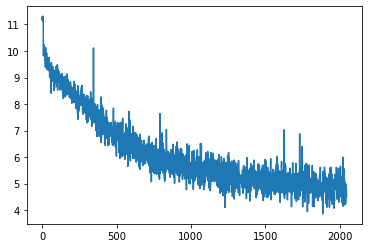

In [96]:
ls = pd.Series(losses)
ls.plot()

In [43]:
rnn_mlm_model.eval()

RNN_MLM(
  (token_embedding): Embedding(36000, 256)
  (up_scale): Linear(in_features=256, out_features=512, bias=True)
  (encoders): ModuleList(
    (0): LSTM(512, 256, batch_first=True, bidirectional=True)
    (1): LSTM(512, 256, batch_first=True, bidirectional=True)
    (2): LSTM(512, 256, batch_first=True, bidirectional=True)
    (3): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (output): Linear(in_features=512, out_features=256, bias=True)
)

In [ ]:
df

In [48]:
para = """Location  Leeds. My client, an [MASK] and growing IT company are currently [MASK] for a Telemarketing Executive. This is an exciting new business sales [MASK] to join a forward thinking [MASK] that continues to go from strength to strength. The Telemarketing Executive role offers an excellent platform for progression to Senior Account Manager. Role Profile: The Telemarketer function is a key position to feed the growth objectives of the organisation. The [MASK] of this position is to drive new clients to a Workshop and/or contact new clients on a range of specific products and service offerings on a project by project basis. The position is a training ground to further graduate onto junior account manager role after approximately ****2 months. It is expected that you will be capable of using the phone and email to convey value of the workshop or project with a qualified decision maker. Key Responsibilities: Your main targets will include: Ability to make **** outbound calls per day To speak with a minimum of 10 decision maker contacts To meet specific project targets E.g. workshop **** delegate per day To meet a minimum of 1 hour call each day Product, industry and service knowledge goals Your consultative style and proactivity will enable you to understand customers business, identify their needs and then leverage this information to achieve the required goal.
"""
toks = tokenizer.encode(f'[CLS] {para} [SEP]')
toks = torch.tensor([toks.ids]).to(device)

In [49]:
output = rnn_mlm_model(toks)
output = output.argmax(dim=-1)[0].cpu()

In [50]:
tokenizer.decode(output.numpy()).replace(' ##', '')

'they location job . my client , an advantage and growing it company are currently looking for a telemarketing executive . this is an exciting new business sales manager to join a forward thinking that that is to go from strength to strength . the telemarketing executive role offers an excellent opportunity for progression to senior account manager . role profile : the and this is a key position to of the growth objectives of the organisation . the role of this position is to drive new clients to a workshop and / or contact new clients on a range of specific products and service and on a project by project basis . the position is a training ground to further graduate and junior account manager role after * * * * * 2 months . it is expected that you will be one of using the phone and email to the value of the workshop or project with a qualified decision team . key responsibilities : your main targets will include : ability to make * * * * outbound calls per day to speak with a minimum 

In [47]:
# df[df.FullDescription.str.contains('data science')]

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
41022,68371267,Analytics & Insights Manager,Analytics Insights Manager Salary: **** **** ...,Central London,Central London,full_time,permanent,RESEARCH TALENT HUB,Teaching Jobs,"50,000 - 65,000 + bonus!",57500,jobs.guardian.co.uk
42977,68495084,MySQL Developer (Data Developer MySQL) London,Award Winner and Market Leader seek a High Cal...,London,London,NaN,contract,SNL Consulting,IT Jobs,340.00 GBP Day,81600,jobserve.com
43060,68495376,"MySQL Data Developer MySQL, Ruby, Datamodelling",MySQL Data Developer Ruby/MySQL/Datamodelling...,London,London,NaN,contract,E Synergy Solutions,IT Jobs,300.00 - 350.00 GBP Day,78000,jobserve.com
43334,68496338,Contract Ruby Developer strong MySQL/APIs,"Contract Ruby Developer, RubyonRails Developer...",London,London,NaN,contract,Harris Global,IT Jobs,350.00 GBP Day,84000,jobserve.com
45661,68549983,ASPNet MVC Developer Lead/Architect,"My client, Big Data Analytics company are look...",London London England,London,NaN,NaN,Redrock Consulting,IT Jobs,50000 -75000 per annum,62500,gojobsearch.co.uk
90977,69169751,Business Intelligence Analyst,BUSINESS INTELLIGENCE ANALYST Reporting to the...,South West London London South East,East Sheen,NaN,permanent,Kelkoo Ltd,IT Jobs,"Up to 32,000 per annum Private Health Care",32000,totaljobs.com
220074,72346028,Head Of Data and Analytics,Exposed solutions are recruiting on behalf of ...,City London South East,London,NaN,permanent,Exposed Solutions,IT Jobs,80000 per annum,80000,cwjobs.co.uk


In [57]:
df.FullDescription[5500]

'Location  Leeds. My client, an established and growing IT company are currently recruiting for a Telemarketing Executive. This is an exciting new business sales opportunity to join a forward thinking organisation that continues to go from strength to strength. The Telemarketing Executive role offers an excellent platform for progression to Senior Account Manager. Role Profile: The Telemarketer function is a key position to feed the growth objectives of the organisation. The intention of this position is to drive new clients to a Workshop and/or contact new clients on a range of specific products and service offerings on a project by project basis. The position is a training ground to further graduate onto junior account manager role after approximately ****2 months. It is expected that you will be capable of using the phone and email to convey value of the workshop or project with a qualified decision maker. Key Responsibilities: Your main targets will include: Ability to make **** ou

In [ ]:
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
import gc
del rnn_mlm_model
del optimizer
gc.collect()

In [ ]:
batch['input_ids'].shape

In [ ]:
output.view(-1, output.shape[-1]).shape

In [ ]:
labels.shape

In [ ]:
out = rnn_mlm_model(batch['input_ids'])

In [ ]:
running_loss = 0.0